In [10]:
import numpy as np
import matplotlib.pyplot as plt

# 픽셀 버퍼
class ImageData:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.data = np.zeros((height, width), dtype=np.uint8)

# 다각형 내부 판정
def point_in_polygon(x, y, polygon):
    inside = False
    n = len(polygon)
    j = n - 1
    for i in range(n):
        xi, yi = polygon[i]
        xj, yj = polygon[j]
        if ((yi > y) != (yj > y)) and \
           (x < (xj - xi) * (y - yi) / ((yj - yi) + 1e-8) + xi):
            inside = not inside
        j = i
    return inside

# 좌표 → 픽셀 인덱스로 변환
def scale_polygon(polygon, x_min, y_min, pixel_size):
    return [((x - x_min) / pixel_size, (y - y_min) / pixel_size) for (x, y) in polygon]

# 다각형 픽셀화
def fill_polygon(image_data, polygon, subpixel=10):
    min_x = int(min(p[0] for p in polygon))
    max_x = int(max(p[0] for p in polygon)) + 1
    min_y = int(min(p[1] for p in polygon))
    max_y = int(max(p[1] for p in polygon)) + 1

    for py in range(min_y, max_y):
        for px in range(min_x, max_x):
            count = 0
            for sy in range(subpixel):
                for sx in range(subpixel):
                    x = px + (sx + 0.5) / subpixel
                    y = py + (sy + 0.5) / subpixel
                    if point_in_polygon(x, y, polygon):
                        count += 1
            coverage = count / (subpixel * subpixel)
            if coverage > 0:
                image_data.data[py, px] = 255


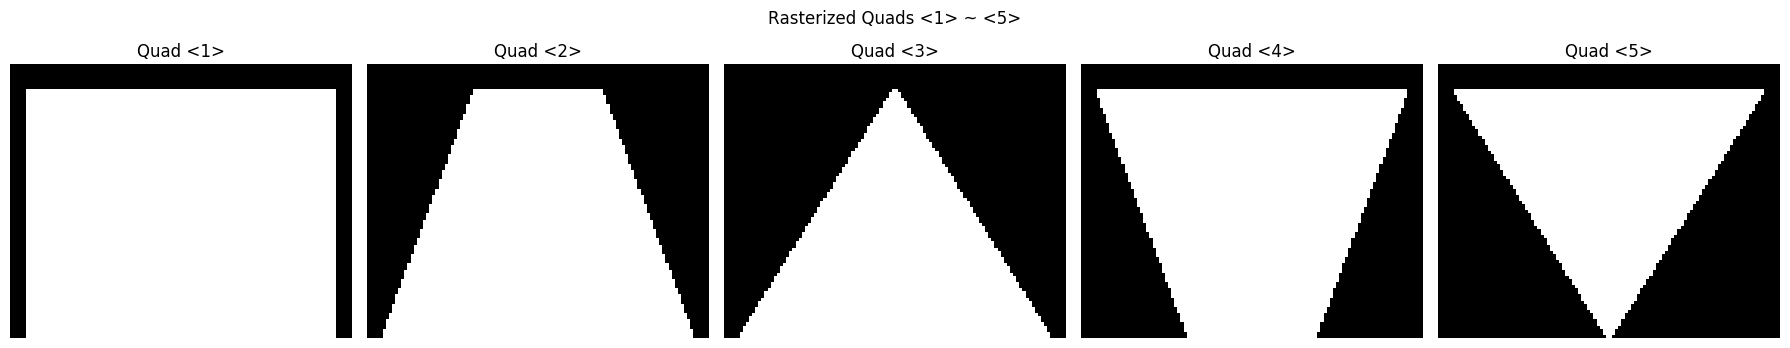

In [22]:
def make_quads(a=0.3, b=0.5, h=0.8):
    return [
        [(-b, 0), (b, 0), (b, h), (-b, h)],       # <1>: 직사각형
        [(-b, 0), (b, 0), (a, h), (-a, h)],       # <2>: 윗면 좁음
        [(-b, 0), (b, 0), (0, h), (0, h)],        # <3>: 윗면 1점
        [(-a, 0), (a, 0), (b, h), (-b, h)],       # <4>: 아랫면 좁음
        [(0, 0), (0, 0), (b, h), (-b, h)]         # <5>: 아랫면 1점
    ]

def compute_bounds(a, b, h, margin_ratio=0.1):
    x_min = -b - (b * margin_ratio)
    x_max = b + (b * margin_ratio)
    y_min = 0.0
    y_max = h + (h * margin_ratio)
    return x_min, x_max, y_min, y_max

a = 0.2
b = 0.5
h = 0.8

x_min, x_max, y_min, y_max = compute_bounds(a, b, h)
pixel_size = 0.01

width = int((x_max - x_min) / pixel_size)
height = int((y_max - y_min) / pixel_size)

img = ImageData(width, height)
quads = make_quads(a, b, h)
# 시각화
fig, axes = plt.subplots(1, 5, figsize=(18, 4))

for i, quad in enumerate(quads):
    img = ImageData(width, height)
    scaled_quad = scale_polygon(quad, x_min, y_min, pixel_size)
    fill_polygon(img, scaled_quad, subpixel=10)

    axes[i].imshow(img.data, cmap="gray", interpolation="nearest", origin="lower")
    axes[i].set_title(f"Quad <{i+1}>")
    axes[i].axis("off")


plt.suptitle("Rasterized Quads <1> ~ <5>")
plt.tight_layout()
plt.show()


In [34]:
import numpy as np

b = 0.5
h = 1.0
polygon = [(-b, 0), (b, 0), (0, h), (0, h)]

def point_in_polygon(x, y, polygon):
    inside = False
    n = len(polygon)
    j = n - 1
    for i in range(n):
        xi, yi = polygon[i]
        xj, yj = polygon[j]
        if ((yi > y) != (yj > y)) and \
           (x < (xj - xi) * (y - yi) / ((yj - yi) + 1e-8) + xi):
            inside = not inside
        j = i
    return inside

resolution = 0.05
region_radius = 0.1
region_size = int((2 * region_radius) / resolution) + 1  # 5x5

x_vals = np.linspace(-0.5, 0.5, int((0.2 / resolution)) + 1)
positions = [(x, 0.1) for x in x_vals]

# ✅ (position, region matrix) 쌍으로 저장
samples = []

for cx, cy in positions:
    matrix = np.zeros((region_size, region_size), dtype=np.uint8)
    for i in range(region_size):
        for j in range(region_size):
            x = cx + (j - region_size // 2) * resolution
            y = cy + (i - region_size // 2) * resolution
            if point_in_polygon(x, y, polygon):
                matrix[i, j] = 1
    samples.append(((cx, cy), matrix))

# ✅ 예시 출력
for pos, mat in samples:
    print(f"\n[Position] {pos}")
    print(mat)



[Position] (-0.5, 0.1)
[[0 0 1 1 1]
 [0 0 0 1 1]
 [0 0 0 1 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]

[Position] (-0.25, 0.1)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]

[Position] (0.0, 0.1)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]

[Position] (0.25, 0.1)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]

[Position] (0.5, 0.1)
[[1 1 1 0 0]
 [1 1 0 0 0]
 [1 1 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]
